# Train DNNs on BrainScaleS-2

This example uses the PyTorch extension `hxtorch`, already presented in the
[introduction to the matrix multiplication](tutorial_4-hagen_properties.ipynb), to train
a deep neural network (DNN).

In order to use the microscheduler we have to set some environment variables first:

In [1]:
from _static.common.helpers import setup_hardware_client
setup_hardware_client()

Some imports that are needed later:

In [2]:
import ipywidgets as w
import numpy as np
import torch
import torch.nn.functional as F
import hxtorch

import matplotlib as mpl
import matplotlib.pyplot as plt
from contextlib import suppress
with suppress(IOError):
    plt.style.use("_static/matplotlibrc")
%matplotlib inline
from IPython.display import HTML
display(HTML("<style>.output_wrapper button.btn-default, "
             ".output_wrapper .ui-dialog-titlebar {display:none}</style>"))

from _static.common.helpers import save_nightly_calibration

## Hardware in the loop

When training on the BrainScaleS-2 system using hxtorch, the multiply
accumulate operation (MAC) in the forward pass is performed on the
hardware, but the gradient is computed on the host computer:

<img src="_static/tutorial/hxtorch_itl.png" style="width:25%;" align="center">

For the calculation of the gradients, a mathematical model is required
that approximately reflects the behavior of the hardware operation. In
hxtorch, the following very simple linear relationship is assumed for
this purpose:

$$
y_i = \sum_j x_j \cdot w_{ij} \cdot g_\text{BSS-2} + \kappa_i\quad\text{with}\quad \kappa_i \sim N(0,\sigma)
$$

Here, the statistical noise $ \kappa_i $ of the neurons is assumed
to be Gaussian distributed with standard deviation $ \sigma $. The
gain factor $ g_\text{BSS-2} $ represents the conversion factor
between the units of the input, weights and the analog-to-digital
converter at the output and is specific to the individual hardware setup
and its calibration.

For the calculations on the host, these parameters can be measured after
initialization of the hardware connection:

In [3]:
# download claibration and initialize hardware configuration
save_nightly_calibration('hagen_cocolist.pbin')
hxtorch.init_hardware(hxtorch.CalibrationPath('hagen_cocolist.pbin'))

# measures the hardware gain and the average statistical noise on the outputs
hardware_parameter = hxtorch.measure_mock_parameter()

print(f"gain factor: {hardware_parameter.gain:.5f}")
print(f"noise std.:  {hardware_parameter.noise_std:.5f}")

# use the measured parameters for backward pass and in mock mode
hxtorch.set_mock_parameter(hardware_parameter)

INFO  00:14:55,051  hxtorch.load_and_apply_calibration Loading calibration from "hagen_cocolist.pbin"
INFO  00:15:02,609  hxtorch.measure_mock_parameter Obtained gain=0.00180094, noise_std=1.4077 at output=66
gain factor: 0.00180
noise std.:  1.40770


## Simulating hardware: The mock mode

The linear model of the hardware presented above can optionally also be
used for the forward pass with hxtorch. It also features the additional
noise, reduced resolution and restricted value ranges of the system.

<img src="_static/tutorial/hxtorch_mock_mode.png" style="width:90%;" align="center">

This so-called mock mode can be switched on and off individually for
each hxtorch operation and for each layer via the `mock` parameter,
e.g.

`hxtorch.matmul(..., mock=True)`

It is especially convenient when no BrainScaleS-2 system is available
and allows fast prototyping of DNN models.

## References for further reading

The integration into the PyTorch software frontend `hxtorch` and a
benchmark on the human activity recognition dataset is published in:

- Spilger, Philipp, et al. “hxtorch: PyTorch for BrainScaleS-2.” IoT
  Streams for Data-Driven Predictive Maintenance and IoT, Edge, and Mobile
  for Embedded Machine Learning. Springer, Cham, 2020. 189-200.
  [https://doi.org/10.1007/978-3-030-66770-2_14](https://doi.org/10.1007/978-3-030-66770-2_14)  


More details on the implementation of the backward pass, the mock mode
and the layer initilization can be found in (chapter 4.2 ff.):

- Emmel, Arne “Inference with Convolutional Neural Networks on Analog
  Neuromorphic Hardware” *Master’s Thesis*. University of Heidelberg.
  [pdf](http://www.kip.uni-heidelberg.de/Veroeffentlichungen/details.php?id=4122)  

## Example application: the Yin-Yang dataset

In [4]:
class YinYangDataset(torch.utils.data.dataset.Dataset):
    """
    The Yin-Yang dataset. Slightly modified version adapted from:
    https://github.com/lkriener/yin_yang_data_set
    """
    def __init__(self, r_small=0.1, r_big=0.5, size=1000, seed=42):
        super(YinYangDataset, self).__init__()
        # numpy RNG to allow compatibility to other learning frameworks
        self.rng = np.random.RandomState(seed)
        self.r_small = r_small
        self.r_big = r_big
        self.size = size

    def get_sample(self, goal=None):
        # sample until goal is satisfied
        found_sample_yet = False
        while not found_sample_yet:
            # sample x,y coordinates
            x, y = self.rng.rand(2) * 2. * self.r_big
            # check if within yin-yang circle
            if np.sqrt((x - self.r_big)**2 + (y - self.r_big)**2) > self.r_big:
                continue
            # check if they have the same class as the goal for this sample
            c = self.which_class(x, y)
            if goal is None or c == goal:
                found_sample_yet = True
                break
        return x, y, c

    def which_class(self, x, y):
        # equations inspired by
        # https://link.springer.com/content/pdf/10.1007/11564126_19.pdf
        d_right = self.dist_to_right_dot(x, y)
        d_left = self.dist_to_left_dot(x, y)
        criterion1 = d_right <= self.r_small
        criterion2 = d_left > self.r_small and d_left <= 0.5 * self.r_big
        criterion3 = y > self.r_big and d_right > 0.5 * self.r_big
        is_yin = criterion1 or criterion2 or criterion3
        is_circles = d_right < self.r_small or d_left < self.r_small
        if is_circles:
            return 2
        return int(is_yin)

    def dist_to_right_dot(self, x, y):
        return np.sqrt((x - 1.5 * self.r_big)**2 + (y - self.r_big)**2)

    def dist_to_left_dot(self, x, y):
        return np.sqrt((x - 0.5 * self.r_big)**2 + (y - self.r_big)**2)

    def __getitem__(self, index):
        # keep num of class instances balanced by using rejection sampling
        # choose class for this sample
        goal_class = self.rng.randint(3)
        x, y, c = self.get_sample(goal=goal_class)
        sample = (torch.tensor([x, y, 1-x, 1-y], dtype=torch.float), c)
        return sample

    def __len__(self):
        return self.size

Let’s take a look at this dataset!

In [5]:
colors = ('black', 'white', 'orange')
class_names = ('yin', 'yang', 'dot')
num_samples = 2000

loader = torch.utils.data.DataLoader(
    dataset=YinYangDataset(size=num_samples),
    batch_size=num_samples)

The samples in the modified version are randomly redrawn each time they are
accessed, so that each sample will be presented to the network only once.
Repeated execution of the following code cell therefore shows slightly different
samples each time. The number of samples is the same for each of the three classes.

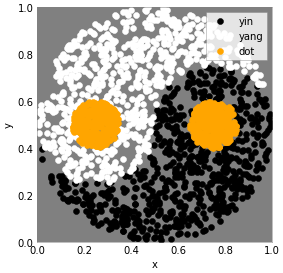

In [6]:
samples, labels = next(iter(loader))

fig, ax = plt.subplots(1,1)
for i in range(3):
    ax.scatter(
        *samples[labels==i][..., :2].t(),
        c=colors[i], label=class_names[i])
ax.set_aspect('equal')
ax.set_facecolor('gray')
ax.set_xlim(0,1); ax.set_ylim(0,1)
ax.set_xlabel("x"); ax.set_ylabel("y")
_=ax.legend()

## Further reading

This dataset as well as some model proposes and benchmarks are presented in:

- Kriener, L., Göltz, J., & Petrovici, M. A. (2021). The Yin-Yang dataset.
  arXiv preprint: [arXiv:2102.08211](https://arxiv.org/abs/2102.08211).  

In [7]:
def alpha_cmap(color):
    """
    Returns a colormap ranging from transparent to specified color
    """
    cmap = np.broadcast_to(mpl.colors.to_rgba(color), (256, 4)).copy()
    cmap[:, -1] = np.linspace(0, 1, 256)
    return mpl.colors.ListedColormap(cmap)

def test_train_epoch(model: torch.nn.Module,
                     loader: torch.utils.data.DataLoader,
                     optimizer: torch.optim.Optimizer):
    """
    Test the model and train for a single epoch afterwards.
    :param model: The model
    :param loader: Data loader containing the train data set
    :param optimizer: Optimizer that handles the weight updates
    """
    # prepare test data (grid of equal spaced samples):
    gridsize = 16  # one dimension of the test grid
    x = y = torch.linspace(0, 1, gridsize)
    x, y = torch.meshgrid(x, y); x, y = x.flatten(), y.flatten()
    data_test = torch.tensor(list(zip(x, y, 1-x, 1-y)), requires_grad=True)
    data, target = next(iter(loader))
    data = torch.cat((data_test, data))  # prepend to train data
    # the actual training:
    model.train()
    optimizer.zero_grad()
    output = model(data)
    loss = F.cross_entropy(output[len(data_test):], target)
    loss.backward()
    optimizer.step()
    # get test data from output and reshape:
    with torch.no_grad():
        output_test = F.softmax(output[:len(data_test)], dim=-1)
    output_test = output_test.reshape(gridsize, gridsize, -1)
    return torch.transpose(output_test, 0, 1)

def train(model: torch.nn.Module,
          loader: torch.utils.data.DataLoader,
          scheduler: torch.optim.lr_scheduler._LRScheduler,
          num_epochs: int = 200):
    """
    Train the model while displaying the test results.
    :param model: The model
    :param loader: Data loader containing the train data set
    :param scheduler: Scheduler that handles the weight updates
    :param num_epochs: Number of epochs to train
    """
    fig = plt.figure()
    ax = plt.gca()
    ax.grid(False)
    ax.set_title("Epoch 0")
    imgs = []
    for i, c in enumerate(colors):
        imgs.append(plt.imshow(
            torch.zeros((1, 1)), vmin=0, vmax=1,
            extent=(0, 1, 0, 1), origin='lower',
            cmap=alpha_cmap(c)))
    plt.xlabel("$x$"); plt.ylabel("$y$")

    for _ in range(num_epochs + 1):
        test_out = test_train_epoch(model, loader, scheduler.optimizer)
        for i, img in enumerate(imgs):
            img.set_data(test_out[..., i])
        ax.set_title(f"Epoch {scheduler.last_epoch}")
        fig.canvas.draw()
        scheduler.step()
    wout = w.Output(layout=w.Layout(height="450px")); display(wout)
    plt.close(); wout.layout=w.Layout(height="0px")

Modeling with hxtorch feels almost like using PyTorch normally, you can
even use layers of hxtorch and PyTorch together. If you are familiar
with PyTorch, the code below will also look familiar to you:

In [8]:
class Model(torch.nn.Module):
    """
    Classify the YinYang dataset.
    """
    def __init__(self, mock: bool = False):
        super().__init__()
        self.classifier = torch.nn.Sequential(
            hxtorch.nn.Linear(4, 128, mock=mock),
            hxtorch.nn.ConvertingReLU(shift=1),
            hxtorch.nn.Linear(128, 3, avg=5, mock=mock),
        )

    def forward(self, *x):
        x = x[0] * 31.  # scale to the whole input range
        x = self.classifier(x)
        return x

In [9]:
model_mock = Model(mock=True)
model_mock

Model(
  (classifier): Sequential(
    (0): Linear(in_features=4, out_features=128, num_sends=38, mock=True)
    (1): ConvertingReLU(shift=1)
    (2): Linear(in_features=128, out_features=3, num_sends=7, mock=True, avg=5)
  )
)

In [10]:
batch_size = 350
lr = 1  # learning rate
gamma = 0.99  # learning parameters decay

loader = torch.utils.data.DataLoader(
    dataset=YinYangDataset(size=batch_size),
    batch_size=batch_size)
scheduler = torch.optim.lr_scheduler.StepLR(
    torch.optim.Adam(model_mock.parameters(), lr=lr),
    step_size=1, gamma=gamma)

In [ ]:
train(model_mock, loader, scheduler, num_epochs=200)

/srv/main-spack-instance-2302/spack/var/spack/environments/experimental/.spack-env/view/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
model_hw = Model(mock=False)
# initialize with state of mock model
model_hw.load_state_dict(model_mock.state_dict())
model_hw

In [ ]:
lr = 0.2
gamma = 0.9

scheduler_hw = torch.optim.lr_scheduler.StepLR(
    torch.optim.Adam(model_hw.parameters(), lr=lr),
    step_size=1, gamma=gamma)

In [ ]:
train(model_hw, loader, scheduler_hw, num_epochs=15)